In [0]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import torchvision.models as torch_models

# Load and Process Data

In [38]:
def healthy(row):
  if row.sum() == 0: return 1
  else: return 0

df_labels = pd.read_csv('drive/My Drive/ICH/train_labels.csv', usecols=[1,2,3,4])
df_labels['none'] = df_labels[['epidural', 'intraparenchymal', 'subarachnoid']].apply(lambda row: healthy(row), axis=1)
df_labels.head(3)

,ID,epidural,intraparenchymal,subarachnoid,none
0,train_0,1,0,1,0
1,train_1,1,0,0,0
2,train_2,1,0,1,0


Convert data to multilabel dataset to suite fast ai api set up

In [0]:
labels = ['epidural', 'intraparenchymal', 'subarachnoid', 'none']

def label(row):
  label = ''
  for l in labels:
    if row[l] == 1:
      label += l + ' '
  return label

df_labels['multilabel'] = df_labels.apply(lambda row: label(row), axis=1)
df_labels['ID'] = df_labels['ID'].apply(lambda x: x + '.png')
df_labels_inj = df_labels[df_labels['none'] == 0]

Images loaded to GPU workstation in train_images file.

Image transformations applied in accordance with procedure detailed in supplementary materials of 'Precise diagnosis of intracranial hemorrhage and subtypes using a three-dimensional joint convolutionaland recurrent neural network' - Yu et al:

**"In the training process, we applied online augmentation to the training images to reduce overfitting, including rotation (0-180 degrees), scaling (90%-110%), shifting (10%), sheering (10%), as well as horizontal and vertical ﬂipping."**

Images are also upscaled to 256x256 as performed in Yu et al.


In [0]:
df_labels[['ID', 'multilabel']].to_csv('multilabel.csv', index=False)

# Train on dataset including healthy patients

In [0]:
data_src = (ImageList.from_df(df=df_labels, path='', folder='train_images').split_by_rand_pct(0.2)
            .label_from_df(cols=['epidural', 'intraparenchymal', 'subarachnoid', 'none'], label_cls=MultiCategoryList, one_hot=True))

p = 0.5
tfms = [[rotate(degrees=(-180, 180),  p=p), crop_pad(p=p), dihedral(p=p, use_on_y=True), zoom(scale=(0.9,1.1), p=p), pad(p=p)],[]]

data = (data_src.transform(tfms, size=256).databunch(bs=24))

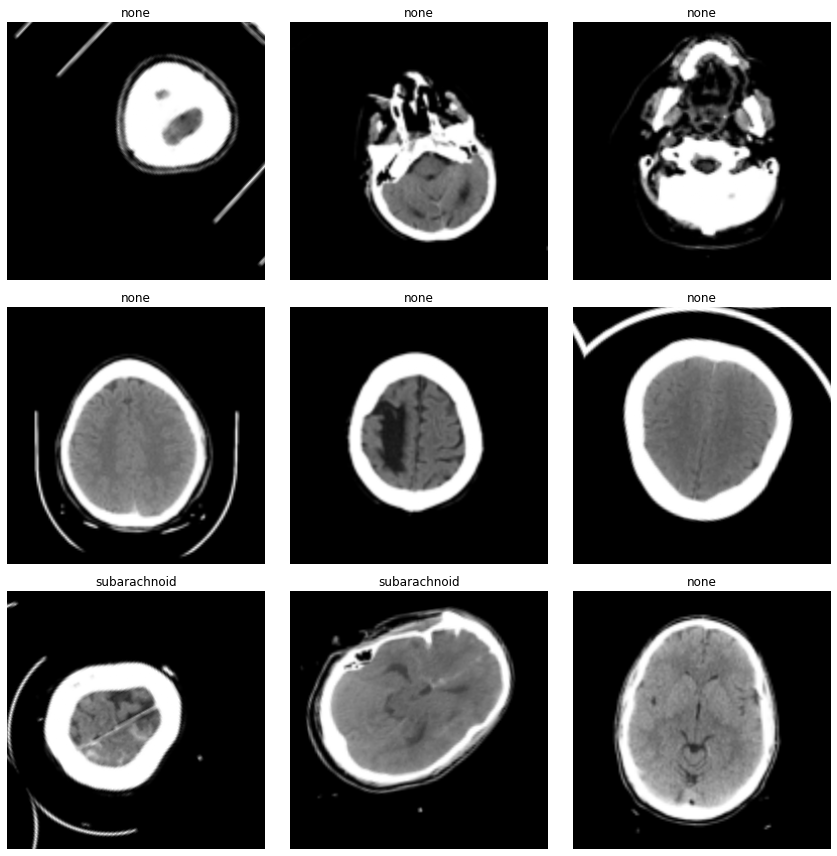

In [55]:
data.show_batch(3)

In [56]:
data.train_ds, data.valid_ds

(LabelList (6834 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: MultiCategoryList
 epidural;subarachnoid,epidural,epidural;subarachnoid,epidural,epidural
 Path: ., LabelList (1708 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: MultiCategoryList
 intraparenchymal;subarachnoid,intraparenchymal;subarachnoid,none,subarachnoid,subarachnoid
 Path: .)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.densenet201, metrics=[acc_02, f_score])

In [58]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


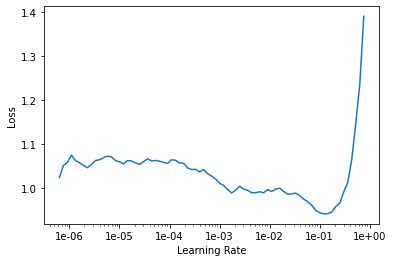

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.693217,0.479057,0.636270,0.746456,02:05
1,0.417202,0.336654,0.813232,0.798974,02:05
2,0.333432,0.295567,0.832553,0.831499,02:05
3,0.314050,0.274225,0.829333,0.845207,02:05
4,0.286839,0.265472,0.848946,0.849925,02:06
5,0.282883,0.264527,0.853776,0.847642,02:06


In [61]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.276108,0.261707,0.851288,0.850781,02:06
1,0.279551,0.259255,0.847190,0.849112,02:06
2,0.270541,0.267851,0.855826,0.844240,02:06


In [0]:
learn.save('densenet-with_healthy')

# Train on injured patients only

In [0]:
data_src = (ImageList.from_df(df=df_labels_inj, path='', folder='train_images').split_by_rand_pct(0.2)
            .label_from_df(cols=['epidural', 'intraparenchymal', 'subarachnoid'], label_cls=MultiCategoryList, one_hot=True))

p = 0.5
tfms = [[rotate(degrees=(-180, 180),  p=p), crop_pad(p=p), dihedral(p=p, use_on_y=True), zoom(scale=(0.9,1.1), p=p), pad(p=p)],[]]

data_inj = (data_src.transform(tfms, size=256).databunch(bs=24))

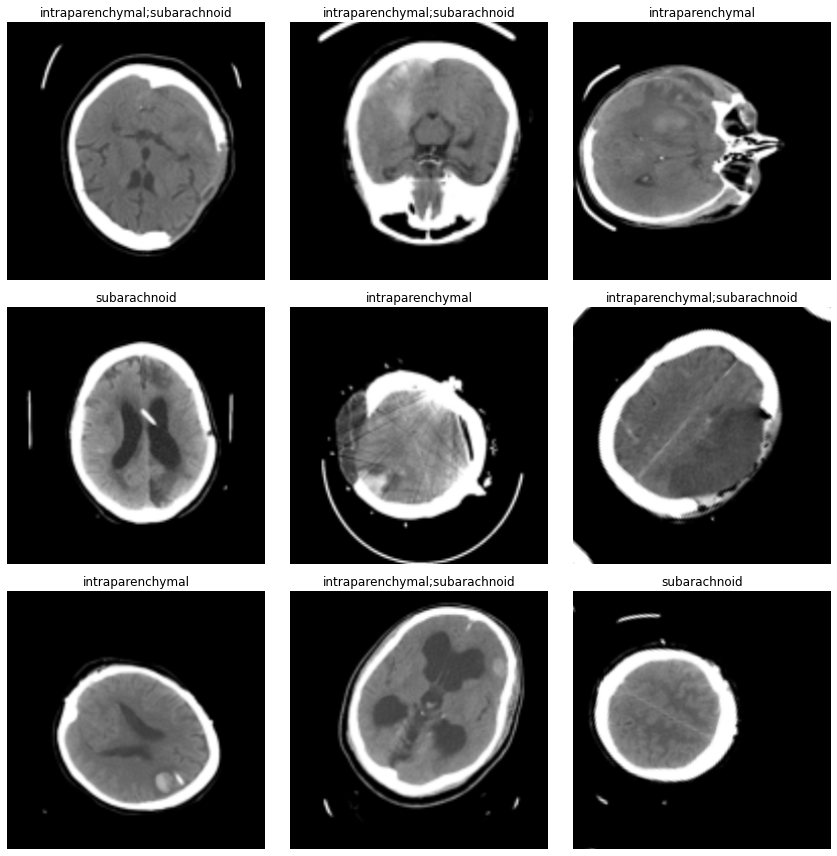

In [66]:
data_inj.show_batch(3)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_inj, models.densenet201, metrics=[acc_02, f_score])

Load weights from training with healthy patients

In [65]:
learn.load('densenet-with_healthy')

Learner(data=ImageDataBunch;

Train: LabelList (4064 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
epidural;subarachnoid,epidural,epidural;subarachnoid,epidural;subarachnoid,epidural
Path: .;

Valid: LabelList (1015 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
subarachnoid,intraparenchymal;subarachnoid,intraparenchymal;subarachnoid,intraparenchymal,intraparenchymal
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (densela

In [67]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


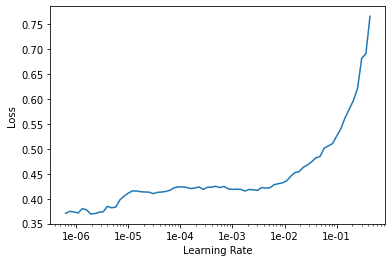

In [68]:
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(5, 1e-6)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.401272,0.340719,0.778325,0.869889,01:15
1,0.396342,0.341440,0.775698,0.867840,01:15
2,0.394220,0.344766,0.778654,0.866296,01:15
3,0.398810,0.340828,0.777340,0.867250,01:15
4,0.404360,0.342757,0.780952,0.868692,01:15


In [70]:
learn.fit_one_cycle(2, 1e-8)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.405091,0.343279,0.781938,0.868848,01:16
1,0.401663,0.341039,0.782923,0.869364,01:15


In [0]:
learn.save('densenet-3-type_injonly')

In [0]:
!mkdir train_images/models

In [0]:
learn.save('../drive/My Drive/ICH/models/densenet-3-type-final')

Generate sequence embeddings from intermediate stage in the model using callback function

In [0]:
!mkdir models

In [0]:
learn.load('../drive/My Drive/ICH/densenet-3-type-final')

Learner(data=ImageDataBunch;

Train: LabelList (4064 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
epidural,epidural;subarachnoid,epidural;subarachnoid,epidural,epidural
Path: .;

Valid: LabelList (1015 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
epidural;intraparenchymal,intraparenchymal,epidural;subarachnoid,subarachnoid,epidural
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (no

In [0]:
learn = learn.load('densenet-with_healthy')

Test output

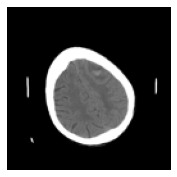

In [83]:
im = open_image('train_images/train_1000.png')
im.show()

In [84]:
df_labels[df_labels['ID'] == 'train_1000.png']

,ID,epidural,intraparenchymal,subarachnoid,none,multilabel
997,train_1000.png,0,1,0,0,intraparenchymal


In [85]:
print(learn.predict(im))

(MultiCategory tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0.0196, 0.7198, 0.4601]))


In [0]:
data.train_ds.classes

['epidural', 'intraparenchymal', 'subarachnoid']

Successfully saved intermediate embedding layer of the model

In [0]:
import os 
img_files = os.listdir('train_images')
img_files.remove('models')

file_names = []
embeddings = []

for i in img_files:
  learn.predict(open_image('train_images/' + i))
  emb = sf.features[0]
  file_names.append(i)
  embeddings.append(emb)

len(embeddings), len(file_names)

(8542, 8542)

In [0]:
np.save('drive/My Drive/ICH/Data/embeddings_3type_densenet_wide_layer', np.array(embeddings))
np.save('drive/My Drive/ICH/Data/embedding_imgnames_3type_densenet', np.array(file_names))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


# Inference

Final inference of class probabilities for train images in order to train random forest classifier and then the same probabilities for the test set

In [0]:
train_img_files = os.listdir('train_images')
# train_img_files.remove('models')

file_names = []
c_scores = []

for i in train_img_files:
  _, _, c = learn.predict(open_image('train_images/' + i))
  file_names.append(i)
  c_scores.append(c)

In [0]:
c1 = [x[0].numpy() for x in c_scores]
c2 = [x[1].numpy() for x in c_scores]
c3 = [x[2].numpy() for x in c_scores]

In [0]:
train_3type_scores = pd.DataFrame({'file': file_names, 'epidural': c1, 'intraparenchymal': c2, 'subarachnoid': c3})
train_3type_scores.to_csv('drive/My Drive/ICH/Inference/train_3type_conf_scores.csv')

The same for test images for final inference

In [0]:
test_img_files = os.listdir('test_images')
# train_img_files.remove('models')

file_names_test = []
c_scores_test = []

for i in test_img_files:
  _, _, c = learn.predict(open_image('test_images/' + i))
  file_names_test.append(i)
  c_scores_test.append(c)

In [0]:
c1 = [x[0].numpy() for x in c_scores_test]
c2 = [x[1].numpy() for x in c_scores_test]
c3 = [x[2].numpy() for x in c_scores_test]

test_3type_scores = pd.DataFrame({'file': test_img_files, 'epidural': c1, 'intraparenchymal': c2, 'subarachnoid': c3})
test_3type_scores.to_csv('drive/My Drive/ICH/Inference/test_3type_conf_scores.csv')